In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "data/mnist/"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 
test_data[:10]

array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [49]:
from scipy.sparse import csr_matrix
class UOM(object):
    #A SOM without 2D structure
    #much faster
    #nnodes: number of neurons
    #alpha: renew rates
    def __init__(self,indata,train_data,nnodes,alpha,init='sample'):
        self.indata = indata
        self.data = train_data
        self.dlen = np.shape(self.data)[0]
        self.nnodes = nnodes
        self.alpha = alpha
        self.init = init
        
    def mxinit(self,indata,nnodes):
        #sample: choose random sample from indata
        #tabula_rasa: random value
        if self.init == 'sample':
            index = np.random.randint(len(indata),size=nnodes)
            matrix = indata[index]
        elif self.init == 'tabula_rasa':
            matrix = np.random.rand(nnodes,np.shape(indata)[1])
        matrix = self.normalize(matrix)
        return matrix
    
    def find_bmu(self,data):
        f_rate = np.dot(data,self.matrix.T)
        bmu = np.argmax(f_rate,axis=1)
        return bmu,f_rate
    
    def train(self,data,r_mode,treshold):
        #update bmu in matrix with according sample
        data = self.normalize(data)
        bmu = self.find_bmu(data)
        self.renew(bmu,data,r_mode,treshold)
        #np.dot(data.T,np.max(bmu[1],axis=1)).T
        self.matrix = self.normalize(self.matrix)
        return self.matrix
    
    def train_we(self,data,we_tr,r_mode,treshold):
        #replace inactive elements with new ones
        data = self.normalize(data)
        bmu = self.find_bmu(data)
        self.renew(bmu,data,r_mode,treshold)
        hitmap = np.bincount(bmu[0])
        remain_list = np.argwhere(hitmap>we_tr)
        #print(np.shape(self.matrix),remain_list)
        add_matrix = self.mxinit(self.indata,self.nnodes-len(remain_list))
        self.matrix = self.matrix[remain_list][:,0,:]
        self.matrix = np.concatenate((self.matrix,add_matrix),axis=0)
        self.matrix = self.normalize(self.matrix)
        return self.matrix
    
    def renew(self,bmu,data,r_mode='none',treshold=0):
        if r_mode=='none':
            self.matrix[bmu[0]] = self.matrix[bmu[0]]+self.alpha*data
        elif r_mode=='rate':
            a_rate = np.max(self.normalize(bmu[1]),axis=1)
            self.matrix[bmu[0]] = self.matrix[bmu[0]]+self.alpha*(data.T*a_rate).T
        elif r_mode=='treshold':
            a_rate = np.max(self.normalize(bmu[1]),axis=1)
            a_rate[(a_rate<treshold)]=0
            a_rate[(a_rate>=treshold)]=1
            self.matrix[bmu[0]] = self.matrix[bmu[0]]+self.alpha*(data.T*a_rate).T
        return self.matrix
            
            
    
    def loop_train(self,loops,re_elect='false',we_tr=1,r_mode='none',treshold=0):
        self.matrix = self.mxinit(self.indata,self.nnodes)
        stl = len(self.data)//loops
        if re_elect=='true':
            for i in range(loops):
                self.train_we(self.data[i*stl:(i+1)*stl],we_tr,r_mode,treshold)
        elif re_elect=='false':
            for i in range(loops):
                self.train(self.data[i*stl:(i+1)*stl],r_mode,treshold)
        return self.matrix 
        
    def normalize(self,weights,mean=1,bias=0):
        newweights = (weights.T/np.sum(weights,axis=1)).T *(np.shape(weights)[1])*mean -bias
        return newweights

In [50]:
M = UOM(train_data[:1000,1:],train_data[10000:15000,1:],40,0.1)
G = M.loop_train(10,r_mode='treshold',treshold=0.3)

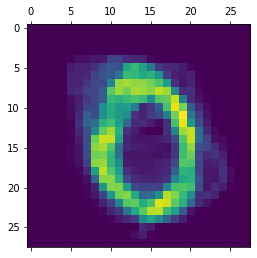

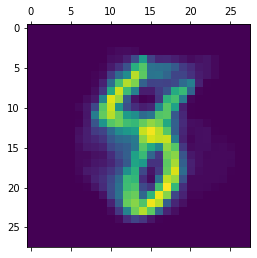

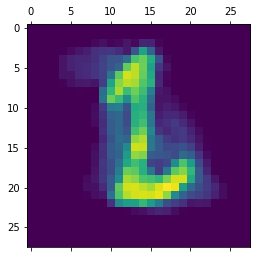

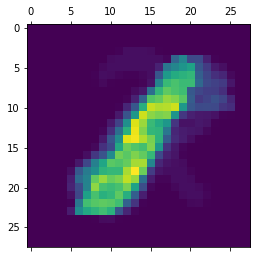

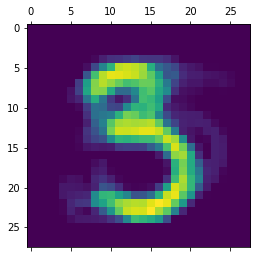

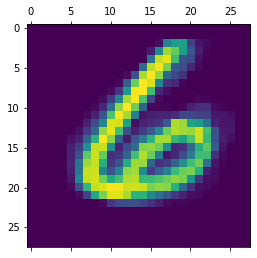

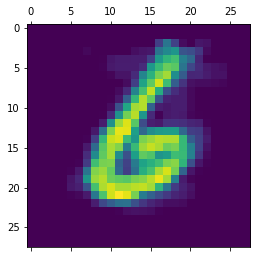

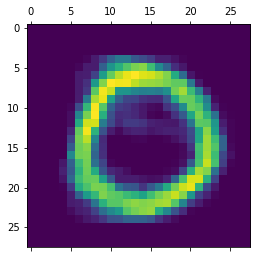

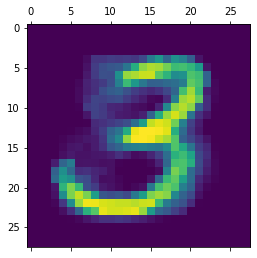

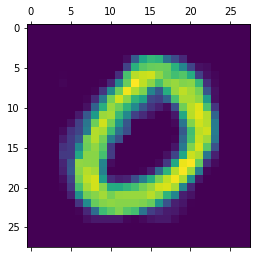

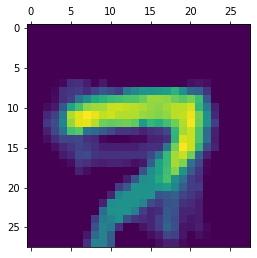

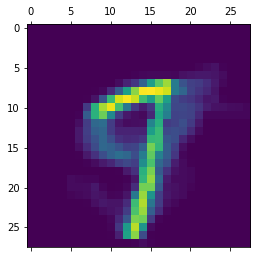

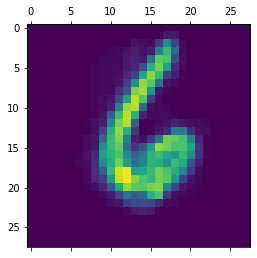

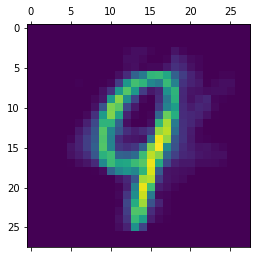

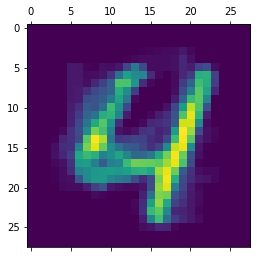

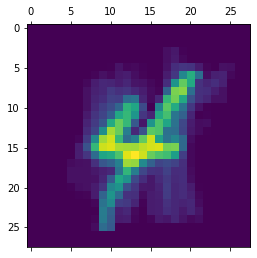

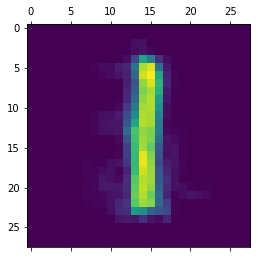

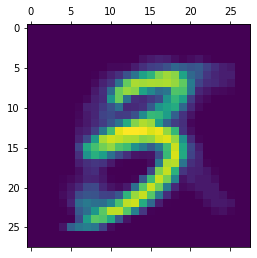

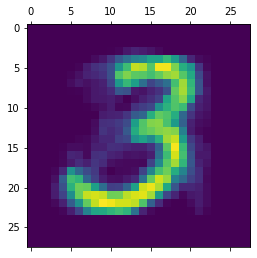

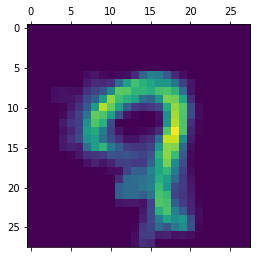

In [51]:
for i in range(20):
    plt.matshow(np.reshape(G[i],(28,28)))

In [7]:
class dreamNN(object):
    def __init__(self,traindata,testdata,nnodes,nol,alpha,acc_rate,):
        #nol: number of labels, how many kinds of different labels do u have
        self.traindata = traindata
        self.testdata = testdata
        self.lb_train = traindata[:,0]
        self.lb_test = testdata[:,0]
        self.nol = nol
        self.nnodes = nnodes
        self.alpha = alpha
        self.acc_rate = acc_rate
    
    def train_UOM(self,inumo,uom_data):
        self.M = UOM(inumo,uom_data,self.nnodes,self.alpha)
        G = self.M.loop_train(10,'true')
        return self.M

    def lblist(self):
        #for traindata, make a bmu/label list by SOM
        #bmumatrix: fire rate for every label every node in SOM
        #bmusamples: firing index in traindata for every SOM node
        bmumatrix = np.zeros((self.nol,self.nnodes))
        bmulist = self.M.find_bmu(self.testdata[:,1:])
        for i in range(self.nnodes):
            bmusamples = np.argwhere(bmulist[0]==i)
            for j in bmusamples:
                bmumatrix[np.intc(self.lb_test[j]),i]+=1 
        return bmumatrix
    
    def som_remain(self,bmumatrix):
        #choose "useful" part from SOM matrix
        total_f = sum(bmumatrix)
        max_f = np.max(bmumatrix,axis=0)
        acc_rate = max_f/(total_f+1)
        #for each non-zero-hit unit, percentage of fire with one label
        #choose_1: SOM nodes that can fire
        #choose_2: SOM nodes can correctly fire
        self.good_p = np.argwhere(acc_rate>self.acc_rate)
        return self.good_p
    
    def test_remain(self,test_data):
        test_bmu = self.M.find_bmu(test_data)[0]
        h_test_index = np.isin(test_bmu,self.good_p)
        h_testdata = test_data[(h_test_index==0)]
        print(len(h_testdata))
        return h_testdata

    def data2lb(self,check_data):
        bmu = np.intc(self.M.find_bmu(check_data)[0])
        #print(bmu)
        labels = self.ind[bmu]
        return labels
    
    def check(self):
        labels = self.testdata[:,0]
        p_labels = self.data2lb(self.testdata[:,1:])
        dv = (labels-p_labels)
        #print(dv)
        rc_sample = self.testdata[np.argwhere(dv!=0)]
        self.rc_sample = rc_sample[:,0,:]
        return self.rc_sample
    
    def sleep(self):
        som_remain = self.M.matrix[np.argwhere(D[0,:]==-1)]
        som_remain = som_remain[:,0,:]
        sp_next = np.concatenate((self.rc_sample[:,1:],som_remain))
        return sp_next


In [9]:
T = dreamNN(train_data[:10000],test_data,1000,10,0.3,0.8)
T.train_UOM(train_data[:10000,1:],train_data[10000:20000,1:])
for i in range(40):
    lm = T.lblist()
    G = T.som_remain(lm)
    H = T.test_remain(train_data[(i*1000):((i+1)*1000),1:])
    new_data = H
    T.M.train(new_data)

544
466
425
386
372
343
298
339
283
254
251
237
212
209
180
173
156
177
154
172
153
149
178
162
144
144
117
135
121
103
129
139
130
138
118
123
128
154
114
122


In [31]:
A = np.asarray([[1,2,3],[4,5,6]])
B = np.asarray([5,6])
A.T*B

array([[ 5, 24],
       [10, 30],
       [15, 36]])